In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os


In [13]:
def read_korean_csv(path: str) -> pd.DataFrame:
    """Try common Korean encodings."""
    for enc in ("utf-8", "cp949", "euc-kr"):
        try:
            return pd.read_csv(path, encoding=enc)
        except UnicodeDecodeError:
            continue
    return pd.read_csv(path)

SALES_PATH = './sales_datas'
STORE_PATH = './store_datas'


# Read sales data files
sales_datas = {}
for file in os.listdir(SALES_PATH):
    if file.endswith('.csv'):
        file_path = os.path.join(SALES_PATH, file)
        sales_datas[file] = read_korean_csv(file_path)

# Read store data files
store_datas = {}
for file in os.listdir(STORE_PATH):
    if file.endswith('.csv'):
        file_path = os.path.join(STORE_PATH, file)
        store_datas[file] = read_korean_csv(file_path)

# Read other files in same directory
# Load only floating_population.csv
floating_population = read_korean_csv('floating_population.csv')

# Print shapes of all loaded dataframes
print("Sales data shapes:")
for name, df in sales_datas.items():
    print(f"{name}: {df.shape}")
print("\nStore data shapes:")
for name, df in store_datas.items():
    print(f"{name}: {df.shape}")
print("\nFloating population data shape:")
print(f"floating_population.csv: {floating_population.shape}")


Sales data shapes:
서울시 상권분석서비스(추정매출-행정동)_2024년.csv: (67900, 53)
서울시_상권분석서비스(추정매출-행정동)_2020년.csv: (66501, 53)
서울시_상권분석서비스(추정매출-행정동)_2021년.csv: (70071, 53)
서울시_상권분석서비스(추정매출-행정동)_2022년.csv: (69440, 53)
서울시_상권분석서비스(추정매출-행정동)_2023년.csv: (68643, 53)

Store data shapes:
서울시 상권분석서비스(점포-행정동)_2023년.csv: (141235, 12)
서울시 상권분석서비스(점포-행정동)_2024년.csv: (141001, 12)
서울시_상권분석서비스(점포-행정동)_2020년.csv: (141611, 12)
서울시_상권분석서비스(점포-행정동)_2021년.csv: (140395, 12)
서울시_상권분석서비스(점포-행정동)_2022년.csv: (140621, 12)

Floating population data shape:
floating_population.csv: (10200, 25)


In [14]:
# sales_datas, store_datas, floating_population 세 데이터를 (기준_년분기_코드, 행정동_코드) 두 열을 기준으로 하여 하나의 데이터로 병합
# Combine all sales data
all_sales = pd.concat(sales_datas.values(), axis=0, ignore_index=True)

# Combine all store data
all_stores = pd.concat(store_datas.values(), axis=0, ignore_index=True)

# Print shapes of combined data
print("Combined sales data shape:", all_sales.shape)
print("Combined store data shape:", all_stores.shape)


Combined sales data shape: (342555, 53)
Combined store data shape: (704863, 12)


In [15]:
# Save district code-name mapping before aggregation
district_code_name_map = all_sales[['행정동_코드', '행정동_코드_명']].drop_duplicates()

# Extract year from 기준_년분기_코드 and create 기준_년 column
all_sales['기준_년'] = all_sales['기준_년분기_코드'].astype(str).str[:4]
all_stores['기준_년'] = all_stores['기준_년분기_코드'].astype(str).str[:4]

# Drop service code columns
all_sales = all_sales.drop(['서비스_업종_코드', '서비스_업종_코드_명'], axis=1)
all_stores = all_stores.drop(['서비스_업종_코드', '서비스_업종_코드_명'], axis=1)

# Aggregate sales data by year and district
sales_agg = all_sales.groupby(['기준_년', '행정동_코드']).sum().reset_index()

# Aggregate store data by year and district
store_agg = all_stores.groupby(['기준_년', '행정동_코드']).agg({
    '점포_수': 'mean',
    '유사_업종_점포_수': 'mean',
    '프랜차이즈_점포_수': 'mean',
    '개업_점포_수': 'sum',
    '폐업_점포_수': 'sum'
}).reset_index()

# Drop 개업_율 and 폐업_률 columns
store_agg = store_agg.drop(['개업_율', '폐업_률'], axis=1, errors='ignore')

# Update original dataframes
all_sales = sales_agg
all_stores = store_agg

# Drop existing district name columns and merge with mapping
all_sales = all_sales.drop('행정동_코드_명', axis=1, errors='ignore').merge(district_code_name_map, on='행정동_코드', how='left')
all_stores = all_stores.drop('행정동_코드_명', axis=1, errors='ignore').merge(district_code_name_map, on='행정동_코드', how='left')


In [16]:
# 그 후, (행정동_코드, 기준_년) 기준으로 중복 제거 (첫 번째 레코드 유지)
all_sales = all_sales.drop_duplicates(subset=['행정동_코드', '기준_년'], keep='first')
all_stores = all_stores.drop_duplicates(subset=['행정동_코드', '기준_년'], keep='first')

# 이후 특성 계산 로직에는 all_sales_cleaned 와 all_stores_cleaned 를 사용합니다.

In [17]:
# Count rows by year for all_sales
print("\nRows per year in all_sales:")
print(all_sales.groupby('기준_년').size())

# Count rows by year for all_stores
print("\nRows per year in all_stores:")
print(all_stores.groupby('기준_년').size())



Rows per year in all_sales:
기준_년
2020    423
2021    424
2022    424
2023    424
2024    424
dtype: int64

Rows per year in all_stores:
기준_년
2020    425
2021    425
2022    425
2023    425
2024    425
dtype: int64


In [18]:
# Convert 기준_년 column to integer type in both dataframes
all_sales['기준_년'] = all_sales['기준_년'].astype(int)
all_stores['기준_년'] = all_stores['기준_년'].astype(int)


In [19]:
import pandas as pd
import numpy as np # np.nan을 사용하기 위해 추가

temp_list = []

for district_code in all_sales['행정동_코드'].unique():
    # Get sales data for this district
    district_sales = all_sales[all_sales['행정동_코드'] == district_code]
    district_stores = all_stores[all_stores['행정동_코드'] == district_code]
    
    # Get last year's data (2023)
    last_year_sales = district_sales[district_sales['기준_년'] == 2023]
    last_year_stores = district_stores[district_stores['기준_년'] == 2023]

    # 이 바로 아래에 디버깅 프린트 추가
    # print(f"District: {district_code} - Found 2023 sales: {len(last_year_sales)}, Found 2023 stores: {len(last_year_stores)}")

    # if len(last_year_sales) == 0 or len(last_year_stores) == 0:
    #     print(f"Skipping district {district_code} due to missing 2023 data.") # 상세 로그
    #     continue
    
    # 데이터 검증 (2023년)
    if len(last_year_sales) == 0 or len(last_year_stores) == 0:
        print(f"Warning: No 2023 data for district {district_code}")
        continue
        
    if len(last_year_sales) > 1 or len(last_year_stores) > 1:
        print(f"Warning: Multiple 2023 records for district {district_code}, processing first one.")
        # 또는 continue로 건너뛸 수 있습니다. 여기서는 첫 번째 레코드를 사용합니다.
        last_year_sales = last_year_sales.iloc[[0]]
        last_year_stores = last_year_stores.iloc[[0]]
        
    metrics = {}
    
    # 작년_총매출액 (컬럼명 수정: '총매출액' -> '당월_매출_금액')
    # 이 값이 연간 총매출액이라고 가정합니다.
    current_year_total_sales = last_year_sales['당월_매출_금액'].iloc[0]
    metrics['작년_총매출액'] = current_year_total_sales
    
    # 작년_점포수
    current_year_store_count = last_year_stores['점포_수'].iloc[0]
    metrics['작년_점포수'] = current_year_store_count
    
    # 작년_점포당평균매출액 (0으로 나누기 방지)
    if current_year_store_count > 0:
        metrics['작년_점포당평균매출액'] = current_year_total_sales / current_year_store_count
    else:
        metrics['작년_점포당평균매출액'] = 0 # 또는 np.nan

    # 작년_연령대2030매출비율 (0으로 나누기 방지)
    age_20_sales = last_year_sales['연령대_20_매출_금액'].iloc[0]
    age_30_sales = last_year_sales['연령대_30_매출_금액'].iloc[0]
    age_20_30_sales = age_20_sales + age_30_sales
    
    if current_year_total_sales > 0:
        metrics['작년_연령대2030매출비율'] = age_20_30_sales / current_year_total_sales
    else:
        metrics['작년_연령대2030매출비율'] = 0 # 또는 np.nan
    
    # Calculate 4-year growth rates (CAGR)
    # 2020년 데이터 가져오기 (컬럼명 수정: '총매출액' -> '당월_매출_금액')
    sales_2020_series = district_sales[district_sales['기준_년'] == 2020]['당월_매출_금액']
    stores_2020_series = district_stores[district_stores['기준_년'] == 2020]['점포_수']
    
    # 2020년 데이터 유효성 검사 및 CAGR 계산
    if len(sales_2020_series) == 0 or len(stores_2020_series) == 0:
        print(f"Warning: No 2020 data for district {district_code} for CAGR calculation.")
        metrics['매출액_연평균증가율_4년전_작년'] = np.nan
        metrics['점포수_연평균증가율_4년전_작년'] = np.nan
    elif len(sales_2020_series) > 1 or len(stores_2020_series) > 1:
        print(f"Warning: Multiple 2020 records for district {district_code}, cannot reliably calculate CAGR. Setting to NaN.")
        metrics['매출액_연평균증가율_4년전_작년'] = np.nan
        metrics['점포수_연평균증가율_4년전_작년'] = np.nan
    else:
        sales_2020_val = sales_2020_series.iloc[0]
        stores_2020_val = stores_2020_series.iloc[0]

        # 매출액_연평균증가율_4년전_작년 (0으로 나누기 방지 및 음수 값으로 인한 복소수 방지)
        if sales_2020_val > 0 and current_year_total_sales >= 0 : # 시작값이 양수, 종료값이 0 이상
            metrics['매출액_연평균증가율_4년전_작년'] = (current_year_total_sales / sales_2020_val) ** (1/3) - 1
        elif sales_2020_val == 0 and current_year_total_sales > 0: # 시작값이 0, 종료값이 양수 (무한 성장률로 간주)
             metrics['매출액_연평균증가율_4년전_작년'] = np.inf # 또는 특정 큰 값이나 np.nan
        else: # 그 외 (시작값이 0이고 종료값도 0, 또는 음수 관련 등) NaN 처리
            metrics['매출액_연평균증가율_4년전_작년'] = np.nan
            
        # 점포수_연평균증가율_4년전_작년 (0으로 나누기 방지 및 음수 값으로 인한 복소수 방지)
        if stores_2020_val > 0 and current_year_store_count >=0:
            metrics['점포수_연평균증가율_4년전_작년'] = (current_year_store_count / stores_2020_val) ** (1/3) - 1
        elif stores_2020_val == 0 and current_year_store_count > 0 :
            metrics['점포수_연평균증가율_4년전_작년'] = np.inf
        else:
            metrics['점포수_연평균증가율_4년전_작년'] = np.nan

    # 작년_순증가점포수
    opened_stores = last_year_stores['개업_점포_수'].iloc[0]
    closed_stores = last_year_stores['폐업_점포_수'].iloc[0]
    metrics['작년_순증가점포수'] = opened_stores - closed_stores
    
    # 작년_프랜차이즈점포비율 (0으로 나누기 방지)
    franchise_stores = last_year_stores['프랜차이즈_점포_수'].iloc[0]
    if current_year_store_count > 0:
        metrics['작년_프랜차이즈점포비율'] = franchise_stores / current_year_store_count
    else:
        metrics['작년_프랜차이즈점포비율'] = 0 # 또는 np.nan
    
    # 작년_주말매출비율 (0으로 나누기 방지)
    weekend_sales = last_year_sales['주말_매출_금액'].iloc[0]
    if current_year_total_sales > 0:
        metrics['작년_주말매출비율'] = weekend_sales / current_year_total_sales
    else:
        metrics['작년_주말매출비율'] = 0 # 또는 np.nan
    
    # 행정동 정보 추가
    metrics['행정동_코드'] = district_code
    # 행정동_코드_명은 2023년 데이터에서 가져오는 것이 더 안전합니다.
    metrics['행정동_코드_명'] = last_year_sales['행정동_코드_명'].iloc[0] 
    
    # Add row to analysis_df
    # analysis_df = pd.concat([analysis_df, pd.DataFrame([metrics])], ignore_index=True) # 기존 코드 활용
    # 또는 리스트에 추가 후 DataFrame으로 변환 (효율성)
    temp_list.append(metrics) # 반복문 전에 temp_list = [] 선언 필요

# 반복문 종료 후:
analysis_df = pd.DataFrame(temp_list) # 만약 temp_list 방식을 사용했다면

# 데이터 검증
print(f"Total districts processed: {len(analysis_df)}")
print(f"Total unique districts in original data: {len(all_sales['행정동_코드'].unique())}")

# 중복 행정동 코드 확인
duplicate_codes = analysis_df['행정동_코드'].duplicated()
if duplicate_codes.any():
    print("Warning: Duplicate district codes found!")
    print(analysis_df[analysis_df['행정동_코드'].duplicated()]['행정동_코드'].unique())
# --- 이전에 제공된 코드 종료 ---

Total districts processed: 424
Total unique districts in original data: 424


In [20]:
# NaN 값을 가진 행을 제거하기 전의 행의 수 확인
print(f"제거 전 analysis_df 행의 수: {len(analysis_df)}")

# CAGR 관련 컬럼에 NaN이 있는 행을 식별합니다.
nan_rows_mask = analysis_df['매출액_연평균증가율_4년전_작년'].isnull() | \
                analysis_df['점포수_연평균증가율_4년전_작년'].isnull()

# NaN이 있는 행을 출력 (어떤 행이 제거되는지 확인용)
print("\n제거될 행 (NaN 포함):")
print(analysis_df[nan_rows_mask][['행정동_코드', '행정동_코드_명', '매출액_연평균증가율_4년전_작년', '점포수_연평균증가율_4년전_작년']])

# NaN 값을 가진 행을 제거합니다. (inplace=False가 기본값이므로 새로운 DataFrame을 할당하거나 inplace=True 사용)
analysis_df = analysis_df.dropna(subset=['매출액_연평균증가율_4년전_작년', '점포수_연평균증가율_4년전_작년'])

# 제거 후 행의 수 확인
print(f"\n제거 후 analysis_df_cleaned 행의 수: {len(analysis_df)}")

# 결측치 재확인
print("\n제거 후 analysis_df_cleaned 내 결측치(NaN) 현황:")
print(analysis_df.isnull().sum())

# 이제부터 analysis_df_cleaned 를 사용합니다.
# 원본 analysis_df를 바로 수정하고 싶다면:
# analysis_df.dropna(subset=['매출액_연평균증가율_4년전_작년', '점포수_연평균증가율_4년전_작년'], inplace=True)
# print(f"\n제거 후 analysis_df (inplace) 행의 수: {len(analysis_df)}")

제거 전 analysis_df 행의 수: 424

제거될 행 (NaN 포함):
       행정동_코드 행정동_코드_명  매출액_연평균증가율_4년전_작년  점포수_연평균증가율_4년전_작년
423  11530800       항동                NaN                NaN

제거 후 analysis_df_cleaned 행의 수: 423

제거 후 analysis_df_cleaned 내 결측치(NaN) 현황:
작년_총매출액              0
작년_점포수               0
작년_점포당평균매출액          0
작년_연령대2030매출비율       0
매출액_연평균증가율_4년전_작년    0
점포수_연평균증가율_4년전_작년    0
작년_순증가점포수            0
작년_프랜차이즈점포비율         0
작년_주말매출비율            0
행정동_코드               0
행정동_코드_명             0
dtype: int64


In [21]:
# hot_place.csv 파일을 데이터프레임으로 임포트
hot_place_df = pd.read_csv('hot_place.csv')

# 데이터 확인
print("Hot Place 데이터 크기:", hot_place_df.shape)
print("\n처음 5개 행:")
print(hot_place_df.head())


Hot Place 데이터 크기: (160, 3)

처음 5개 행:
     행정동_코드 행정동_코드_명  라벨
0  11110515    청운효자동   0
1  11110550      부암동   0
2  11110570      무악동   0
3  11110600      가회동   0
4  11110630  종로5·6가동   0


In [22]:
# analysis_df와 hot_place_df를 행정동 코드 기준으로 병합 (행정동_코드_명 제외)
merged_df = pd.merge(analysis_df, hot_place_df[['행정동_코드', '라벨']], on='행정동_코드', how='left')
# 라벨 열 이름을 is_hot_place로 변경
merged_df = merged_df.rename(columns={'라벨': 'is_hot_place'})

# 병합 결과 확인
print("병합 후 데이터 크기:", merged_df.shape)
print("\n처음 5개 행:")
print(merged_df.head())

# 병합된 데이터의 결측치 확인
print("\n병합된 데이터의 결측치 현황:")
print(merged_df.isnull().sum())


병합 후 데이터 크기: (425, 12)

처음 5개 행:
        작년_총매출액     작년_점포수   작년_점포당평균매출액  작년_연령대2030매출비율  매출액_연평균증가율_4년전_작년  \
0  102968503893  11.617834  8.862969e+09        0.368598           0.139735   
1  406826216993  29.038674  1.400981e+10        0.325067           0.191348   
2  159263102866  10.823755  1.471422e+10        0.444640           0.236425   
3   30105720758   5.872964  5.126154e+09        0.246964           0.259042   
4   36618679318   8.170886  4.481604e+09        0.155560          -0.015579   

   점포수_연평균증가율_4년전_작년  작년_순증가점포수  작년_프랜차이즈점포비율  작년_주말매출비율    행정동_코드 행정동_코드_명  \
0           0.049144         27      0.030976   0.253130  11110515    청운효자동   
1           0.021298         42      0.074391   0.199293  11110530      사직동   
2           0.029038         18      0.064425   0.411176  11110540      삼청동   
3           0.021913        -16      0.068220   0.266272  11110550      부암동   
4          -0.006584         16      0.061967   0.308903  11110560      평창동   

   is_hot_place  

In [23]:
# is_hot_place 열이 존재하는 행만 선택
train_df = merged_df.dropna(subset=['is_hot_place'])

# 선택된 데이터의 크기 출력
print("학습용 데이터셋 크기:", train_df.shape)
print("\n처음 5개 행:")
print(train_df.head())

# is_hot_place 값의 분포 확인
print("\nis_hot_place 값의 분포:")
print(train_df['is_hot_place'].value_counts())


학습용 데이터셋 크기: (160, 12)

처음 5개 행:
        작년_총매출액     작년_점포수   작년_점포당평균매출액  작년_연령대2030매출비율  매출액_연평균증가율_4년전_작년  \
0  102968503893  11.617834  8.862969e+09        0.368598           0.139735   
3   30105720758   5.872964  5.126154e+09        0.246964           0.259042   
5   31611134909   2.966942  1.065445e+10        0.162985           0.188768   
7  118124736705   8.468750  1.394831e+10        0.433698           0.325182   
9  435551588520  23.612308  1.844596e+10        0.217931           0.100048   

   점포수_연평균증가율_4년전_작년  작년_순증가점포수  작년_프랜차이즈점포비율  작년_주말매출비율    행정동_코드 행정동_코드_명  \
0           0.049144         27      0.030976   0.253130  11110515    청운효자동   
3           0.021913        -16      0.068220   0.266272  11110550      부암동   
5           0.011360          1      0.118384   0.150640  11110570      무악동   
7           0.046059          0      0.071751   0.306224  11110600      가회동   
9           0.008663         17      0.049388   0.232043  11110630  종로5?6가동   

   is_hot_place  

In [24]:
# train_df를 train과 test로 분할 (7.5:2.5 비율)
from sklearn.model_selection import train_test_split

# 특성(X)과 타겟(y) 분리
X = train_df.drop(['행정동_코드', '행정동_코드_명', 'is_hot_place'], axis=1)
y = train_df['is_hot_place']

# train_test_split을 사용하여 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.25,  # 25%를 테스트 데이터로 사용
    random_state=42,  # 재현성을 위한 시드 설정
    stratify=y  # 타겟 변수의 분포를 유지
)

# 분할 결과 확인
print("학습 데이터 크기:", X_train.shape)
print("테스트 데이터 크기:", X_test.shape)
print("\n학습 데이터의 타겟 분포:")
print(y_train.value_counts(normalize=True))
print("\n테스트 데이터의 타겟 분포:")
print(y_test.value_counts(normalize=True))


학습 데이터 크기: (120, 9)
테스트 데이터 크기: (40, 9)

학습 데이터의 타겟 분포:
is_hot_place
0.0    0.741667
1.0    0.258333
Name: proportion, dtype: float64

테스트 데이터의 타겟 분포:
is_hot_place
0.0    0.75
1.0    0.25
Name: proportion, dtype: float64


In [109]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np


# Stratified K-Fold 설정
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 모델별 하이퍼파라미터 그리드 정의
param_grids = {
    'logistic': [
        {
            'solver': ['liblinear'],
            'penalty': ['l1', 'l2'],
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            # 'class_weight': ['balanced', None] # 필요시 추가
        },
        {
            'solver': ['saga'],
            'penalty': ['l1', 'l2', 'elasticnet', None],
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'l1_ratio': np.linspace(0, 1, 5) if 'elasticnet' in ['l1', 'l2', 'elasticnet', None] else None, # saga + elasticnet 사용 시 필요
            # 'class_weight': ['balanced', None] # 필요시 추가
        }
    ],
    'xgb': {
        'max_depth': [3, 4, 5],
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [50, 100, 150],
        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
        'gamma': [0, 0.1, 0.5, 1],
        'reg_alpha': [0, 0.01, 0.1, 1],
        'reg_lambda': [0, 0.1, 1, 5],

        # 'scale_pos_weight': [1, 2.9] # sum(negative_instances) / sum(positive_instances)
    },
    'lgb': {
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [50, 100, 150],
        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
        'max_depth': [3, 4, 5],
        'num_leaves': [8, 15, 20],
        'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
        'reg_alpha': [0, 0.01, 0.1, 1],
        'reg_lambda': [0, 0.1, 1, 5],

        # 'scale_pos_weight': [1, 2.9],
        # 'class_weight': ['balanced', None],
        # 'scale_pos_weight': [1, 2.9],
        # 'is_unbalance': [True, False]
    },
    'rf': {
        'n_estimators': [50, 100, 150, 200],
        'max_depth': [3, 5, 7, 10],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 4, 8],
        'max_features': ['sqrt', 'log2', None],

        # 'class_weight': ['balanced', None, 'balanced_subsample']
    }
}

# 모델 정의
models = {
    'logistic': LogisticRegression(random_state=42),
    'xgb': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='aucpr'),
    'lgb': LGBMClassifier(random_state=42, verbosity=-1),
    'rf': RandomForestClassifier(random_state=42)
}

# 각 모델에 대한 GridSearchCV 수행
results = {}
for model_name, model in models.items():
    print(f"\n{model_name.upper()} 모델 학습 중...")
    
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[model_name],
        cv=skf,
        scoring='average_precision',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
    # 결과 저장
    results[model_name] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'best_model': grid_search.best_estimator_
    }
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best AUPRC score: {grid_search.best_score_:.4f}")

# 결과 비교
print("\n모델별 최고 성능 비교:")
for model_name, result in results.items():
    print(f"{model_name.upper()}: {result['best_score']:.4f}")



LOGISTIC 모델 학습 중...
Fitting 5 folds for each of 132 candidates, totalling 660 fits


c:\Users\vega4\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Best AUPRC score: 0.5525

XGB 모델 학습 중...
Fitting 5 folds for each of 43200 candidates, totalling 216000 fits


c:\Users\vega4\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:55:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters: {'colsample_bytree': 0.7, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'reg_alpha': 1, 'reg_lambda': 5, 'subsample': 0.8}
Best AUPRC score: 0.6339

LGB 모델 학습 중...
Fitting 5 folds for each of 32400 candidates, totalling 162000 fits
Best parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 8, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 0.6}
Best AUPRC score: 0.5947

RF 모델 학습 중...
Fitting 5 folds for each of 768 candidates, totalling 3840 fits
Best parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best AUPRC score: 0.5987

모델별 최고 성능 비교:
LOGISTIC: 0.5525
XGB: 0.6339
LGB: 0.5947
RF: 0.5987



### 각 모델의 최적 파라미터 ###

LOGISTIC 최적 파라미터:
{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}

XGB 최적 파라미터:
{'colsample_bytree': 0.7, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'reg_alpha': 1, 'reg_lambda': 5, 'subsample': 0.8}

LGB 최적 파라미터:
{'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 8, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 0.6}

RF 최적 파라미터:
{'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}

### 각 모델별 테스트 데이터 예측 확률 계산 중... ###
LOGISTIC 테스트 예측 확률 shape: (40,)
XGB 테스트 예측 확률 shape: (40,)
LGB 테스트 예측 확률 shape: (40,)
RF 테스트 예측 확률 shape: (40,)


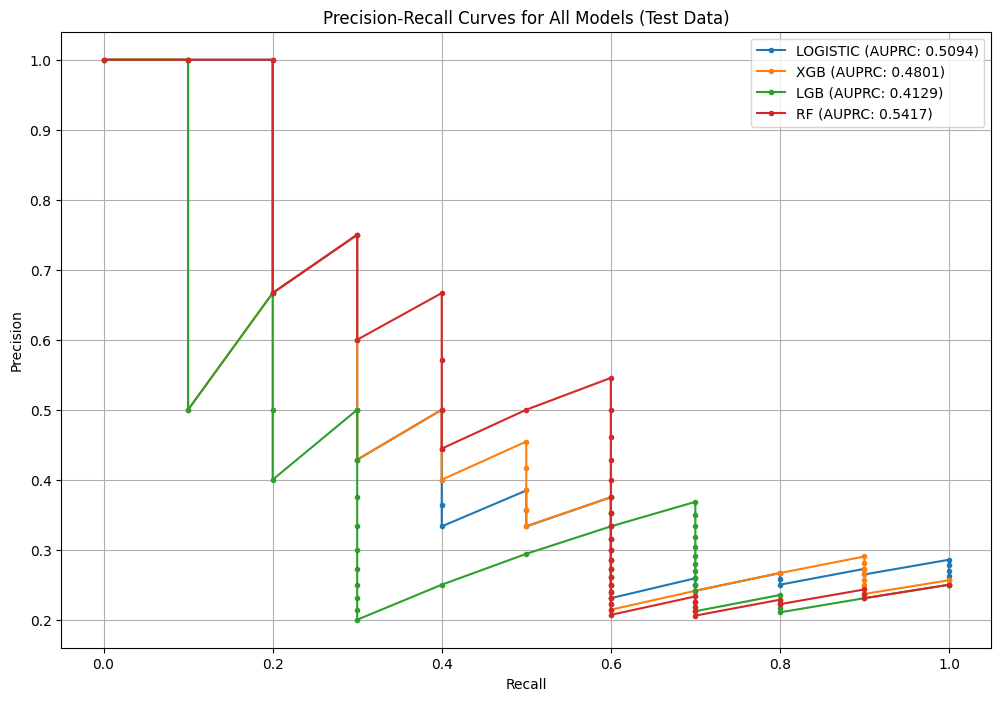


--- 테스트 데이터(Test Data)에 대한 임계값별 성능 평가 ---

LOGISTIC 모델 (Test AUPRC: 0.5094)의 임계값별 성능 변화:
Threshold | Precision | Recall    | F1-Score 
-------------------------------------------------
0.10      | 0.2857    | 1.0000    | 0.4444   
0.15      | 0.2667    | 0.8000    | 0.4000   
0.20      | 0.2500    | 0.6000    | 0.3529   
0.25      | 0.3571    | 0.5000    | 0.4167   
0.30      | 0.3636    | 0.4000    | 0.3810   
0.35      | 0.4286    | 0.3000    | 0.3529   
0.40      | 0.6000    | 0.3000    | 0.4000   
0.45      | 0.6000    | 0.3000    | 0.4000   
0.50      | 0.7500    | 0.3000    | 0.4286   
0.55      | 0.6667    | 0.2000    | 0.3077   
0.60      | 1.0000    | 0.1000    | 0.1818   
0.65      | 0.0000    | 0.0000    | 0.0000   
0.70      | 0.0000    | 0.0000    | 0.0000   
0.75      | 0.0000    | 0.0000    | 0.0000   
0.80      | 0.0000    | 0.0000    | 0.0000   
0.85      | 0.0000    | 0.0000    | 0.0000   
0.90      | 0.0000    | 0.0000    | 0.0000   
0.95      | 0.0000    | 0.0000  

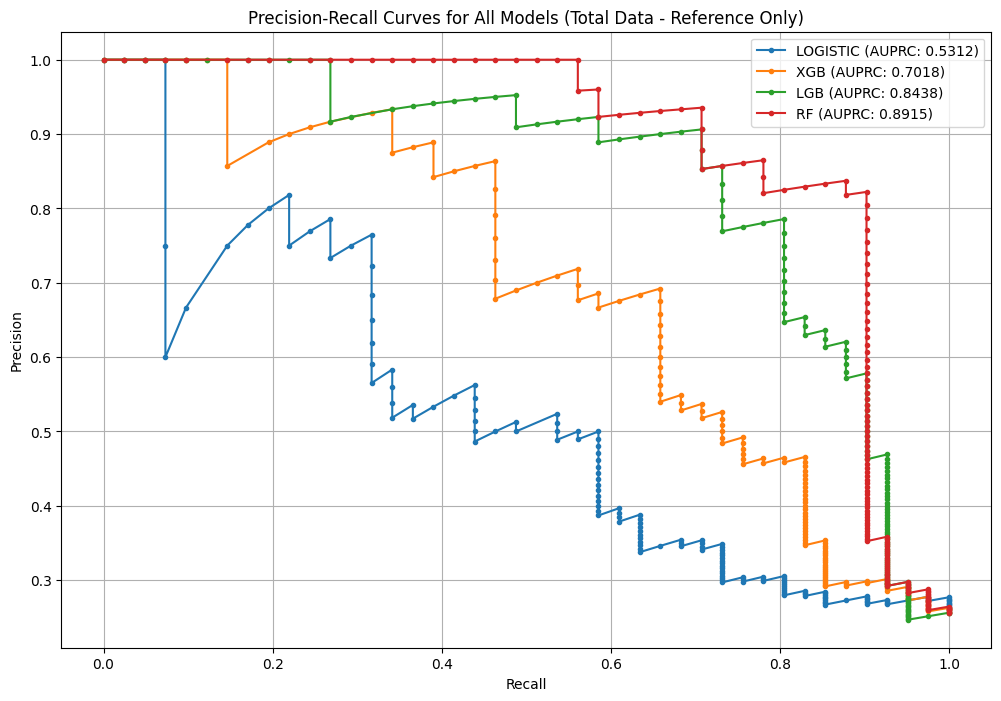


LOGISTIC 모델 (Total AUPRC: 0.5312)의 임계값별 성능 변화 (전체 데이터 참고용):
Threshold | Precision | Recall    | F1-Score 
-------------------------------------------------
0.10      | 0.2752    | 1.0000    | 0.4316   
0.15      | 0.2846    | 0.8537    | 0.4268   
0.20      | 0.3333    | 0.7317    | 0.4580   
0.25      | 0.4000    | 0.5854    | 0.4752   
0.30      | 0.5128    | 0.4878    | 0.5000   
0.35      | 0.5172    | 0.3659    | 0.4286   
0.40      | 0.5385    | 0.3415    | 0.4179   
0.45      | 0.6842    | 0.3171    | 0.4333   
0.50      | 0.7333    | 0.2683    | 0.3929   
0.55      | 0.7500    | 0.2195    | 0.3396   
0.60      | 0.7500    | 0.1463    | 0.2449   
0.65      | 0.6000    | 0.0732    | 0.1304   
0.70      | 1.0000    | 0.0732    | 0.1364   
0.75      | 1.0000    | 0.0244    | 0.0476   
0.80      | 1.0000    | 0.0244    | 0.0476   
0.85      | 1.0000    | 0.0244    | 0.0476   
0.90      | 0.0000    | 0.0000    | 0.0000   
0.95      | 0.0000    | 0.0000    | 0.0000   

XGB 모델 (Total 

In [114]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_curve, average_precision_score, \
                            precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

# --- 이전에 GridSearchCV 결과인 'results', 그리고 X_train, y_train, X_test, y_test가 준비되어 있다고 가정 ---

# 최적 모델 가져오기
best_models = {
    'logistic': results['logistic']['best_model'],
    'xgb': results['xgb']['best_model'],
    'lgb': results['lgb']['best_model'],
    'rf': results['rf']['best_model']
}

# 각 모델의 최적 파라미터 출력
print("\n### 각 모델의 최적 파라미터 ###")
for model_name, model_details in results.items():
    print(f"\n{model_name.upper()} 최적 파라미터:")
    print(model_details['best_params'])

# 각 모델별 테스트 데이터 예측 확률 계산
y_pred_proba_test = {}
print("\n### 각 모델별 테스트 데이터 예측 확률 계산 중... ###")
for model_name, model_object in best_models.items():
    y_pred_proba_test[model_name] = model_object.predict_proba(X_test)[:, 1]
    print(f"{model_name.upper()} 테스트 예측 확률 shape:", y_pred_proba_test[model_name].shape)

# 각 모델별 Precision-Recall Curve 시각화 (테스트 데이터 기준)
plt.figure(figsize=(12, 8))
for model_name, proba in y_pred_proba_test.items():
    precision, recall, _ = precision_recall_curve(y_test, proba) # thresholds는 사용하지 않으므로 _로 받음
    plt.plot(recall, precision, marker='.', label=f"{model_name.upper()} (AUPRC: {average_precision_score(y_test, proba):.4f})")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for All Models (Test Data)')
plt.legend()
plt.grid(True)
plt.show()

# --- 테스트 데이터에 대한 임계값별 성능 평가 ---
print("\n--- 테스트 데이터(Test Data)에 대한 임계값별 성능 평가 ---")
target_precision = 0.8  # 목표 정밀도
best_thresholds_test = {}

for model_name, proba in y_pred_proba_test.items():
    model_auprc_test = average_precision_score(y_test, proba) # 모델의 전체 AUPRC (테스트 데이터 기준)
    print(f"\n{model_name.upper()} 모델 (Test AUPRC: {model_auprc_test:.4f})의 임계값별 성능 변화:")
    print("Threshold | Precision | Recall    | F1-Score ")
    print("-------------------------------------------------")
    
    found_optimal_threshold_for_model = False
    optimal_threshold_info = {
        'threshold': None, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'auprc': model_auprc_test
    }

    for th in np.arange(0.1, 1.0, 0.05):
        y_pred_custom_threshold = (proba >= th).astype(int)
        prec = precision_score(y_test, y_pred_custom_threshold, pos_label=1, zero_division=0)
        rec = recall_score(y_test, y_pred_custom_threshold, pos_label=1, zero_division=0)
        f1 = f1_score(y_test, y_pred_custom_threshold, pos_label=1, zero_division=0)
        print(f"{th:<9.2f} | {prec:<9.4f} | {rec:<9.4f} | {f1:<9.4f}")

        if prec >= target_precision:
            if not found_optimal_threshold_for_model or \
               prec > optimal_threshold_info['precision'] or \
               (prec == optimal_threshold_info['precision'] and rec > optimal_threshold_info['recall']):
                found_optimal_threshold_for_model = True
                optimal_threshold_info.update({'threshold': th, 'precision': prec, 'recall': rec, 'f1': f1})
    
    best_thresholds_test[model_name] = optimal_threshold_info

    if found_optimal_threshold_for_model:
        print(f"\n{model_name.upper()} 모델 (Test): 목표 정밀도 ({target_precision:.2f}) 이상 달성")
        print(f"  추천 임계값: {optimal_threshold_info['threshold']:.4f}")
        print(f"  이때 정밀도: {optimal_threshold_info['precision']:.4f}, 재현율: {optimal_threshold_info['recall']:.4f}, F1: {optimal_threshold_info['f1']:.4f}")
    else:
        # (이전과 동일한 "목표 미달 시 참고 정보 출력" 로직)
        all_threshold_metrics = []
        for th_inner in np.arange(0.1, 1.0, 0.05):
            y_pred_inner = (proba >= th_inner).astype(int)
            prec_inner = precision_score(y_test, y_pred_inner, pos_label=1, zero_division=0)
            if prec_inner > 0 :
                 rec_inner = recall_score(y_test, y_pred_inner, pos_label=1, zero_division=0)
                 f1_inner = f1_score(y_test, y_pred_inner, pos_label=1, zero_division=0)
                 all_threshold_metrics.append({'th': th_inner, 'prec': prec_inner, 'rec': rec_inner, 'f1': f1_inner})
        if all_threshold_metrics:
            best_overall_precision_info = max(all_threshold_metrics, key=lambda x: x['prec'])
            print(f"\n{model_name.upper()} 모델 (Test): 목표 정밀도 ({target_precision:.2f})를 달성하는 임계값을 찾지 못했습니다.")
            print(f"  (참고) 가장 높았던 정밀도: {best_overall_precision_info['prec']:.4f} (임계값: {best_overall_precision_info['th']:.2f}, 재현율: {best_overall_precision_info['rec']:.4f})")
        else:
            print(f"\n{model_name.upper()} 모델 (Test): 목표 정밀도 ({target_precision:.2f})를 달성하는 임계값을 찾지 못했으며, 유효한 예측을 생성하지 못했습니다.")

print("\n### 테스트 데이터 기준 각 모델별 최적 임계값 및 성능 요약 (목표 정밀도 달성 시) ###")
for model_name, info in best_thresholds_test.items():
    if info['threshold'] is not None:
        print(f"{model_name.upper()}: 임계값={info['threshold']:.4f}, 정밀도={info['precision']:.4f}, 재현율={info['recall']:.4f}, F1={info['f1']:.4f}, AUPRC(Test)={info['auprc']:.4f}")
    else:
        print(f"{model_name.upper()}: 목표 정밀도({target_precision:.2f}) 달성 임계값 없음 (Test AUPRC: {info['auprc']:.4f})")

# --- 전체 데이터에 대한 임계값별 성능 평가 (참고용) ---
print("\n--- 전체 데이터(Total Data)에 대한 임계값별 성능 평가 (참고용) ---")
# 전체 데이터셋 생성 (X_train, X_test, y_train, y_test가 이미 정의되어 있다고 가정)
if 'X_train' in locals() and 'X_test' in locals() and 'y_train' in locals() and 'y_test' in locals():
    X_total = pd.concat([X_train, X_test], ignore_index=True)
    y_total = pd.concat([y_train, y_test], ignore_index=True)

    y_pred_proba_total = {}
    print("\n### 각 모델별 전체 데이터 예측 확률 계산 중... ###")
    for model_name, model_object in best_models.items():
        y_pred_proba_total[model_name] = model_object.predict_proba(X_total)[:, 1] # X_total 사용
        print(f"{model_name.upper()} 전체 예측 확률 shape:", y_pred_proba_total[model_name].shape)

    # 각 모델별 Precision-Recall Curve 시각화 (전체 데이터 기준, 참고용)
    plt.figure(figsize=(12, 8))
    for model_name, proba_total in y_pred_proba_total.items():
        precision_total, recall_total, _ = precision_recall_curve(y_total, proba_total)
        plt.plot(recall_total, precision_total, marker='.', label=f"{model_name.upper()} (AUPRC: {average_precision_score(y_total, proba_total):.4f})")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves for All Models (Total Data - Reference Only)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # 임계값별 성능 출력 (전체 데이터)
    for model_name, proba_total in y_pred_proba_total.items():
        model_auprc_total = average_precision_score(y_total, proba_total)
        print(f"\n{model_name.upper()} 모델 (Total AUPRC: {model_auprc_total:.4f})의 임계값별 성능 변화 (전체 데이터 참고용):")
        print("Threshold | Precision | Recall    | F1-Score ")
        print("-------------------------------------------------")
        for th in np.arange(0.1, 1.0, 0.05):
            y_pred_custom_threshold_total = (proba_total >= th).astype(int)
            prec_total = precision_score(y_total, y_pred_custom_threshold_total, pos_label=1, zero_division=0)
            rec_total = recall_score(y_total, y_pred_custom_threshold_total, pos_label=1, zero_division=0)
            f1_total = f1_score(y_total, y_pred_custom_threshold_total, pos_label=1, zero_division=0)
            print(f"{th:<9.2f} | {prec_total:<9.4f} | {rec_total:<9.4f} | {f1_total:<9.4f}")
else:
    print("\n전체 데이터셋(X_train, X_test, y_train, y_test)이 준비되지 않아 전체 데이터 평가는 건너뜁니다.")

- 테스트 스코어가 밸런스있는 rf의 threshold 0.45, 0.5
- 테스트 스코어의 precision이 높은 rf의 threshold 0.5, 0.55
- rf 하이퍼파라미터 : {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}}

## 하이퍼파라미터 검정 및 threshold 검정 코드 대체 코드

In [27]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split # 만약 X_train 등이 없다면 필요

# --- 데이터 준비 ---
# 이전에 사용했던 X_train, y_train, X_test, y_test가 현재 환경에 로드되어 있어야 합니다.
# 예시:
# X = # 전체 특성 데이터
# y = # 전체 라벨 데이터
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)
# print("X_train shape:", X_train.shape)
# print("X_test shape:", X_test.shape)

# 1. 이전에 얻은 최적 하이퍼파라미터 정의
print("이전에 얻은 최적 하이퍼파라미터를 사용합니다.")
best_params_logistic = {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
best_params_xgb = {'colsample_bytree': 0.7, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'reg_alpha': 1, 'reg_lambda': 5, 'subsample': 0.8}
best_params_lgb = {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 8, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 0.6}
best_params_rf = {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}

# (선택 사항) 이전 GridSearchCV의 best_score_ (AUPRC) 값들 (임계값 조정 코드에서 직접 사용되진 않음)
# best_auprc_logistic = 0.5525
# best_auprc_xgb = 0.6339
# best_auprc_lgb = 0.5947
# best_auprc_rf = 0.5987

# 2. 모델 초기화 및 전체 X_train, y_train으로 재학습
print("\n최적 하이퍼파라미터로 모델 재학습 중...")

model_logistic = LogisticRegression(**best_params_logistic, random_state=42, max_iter=1000) # ConvergenceWarning 방지용 max_iter
model_logistic.fit(X_train, y_train)
print("LOGISTIC 모델 재학습 완료.")

model_xgb = XGBClassifier(**best_params_xgb, random_state=42, use_label_encoder=False, eval_metric='aucpr')
model_xgb.fit(X_train, y_train)
print("XGB 모델 재학습 완료.")

model_lgb = LGBMClassifier(**best_params_lgb, random_state=42, verbosity=-1) # LightGBM 로그 줄이기
model_lgb.fit(X_train, y_train)
print("LGB 모델 재학습 완료.")

model_rf = RandomForestClassifier(**best_params_rf, random_state=42)
model_rf.fit(X_train, y_train)
print("RF 모델 재학습 완료.")

# 3. 'best_models' 딕셔너리 생성 (임계값 조정 코드에서 사용)
best_models = {
    'logistic': model_logistic,
    'xgb': model_xgb,
    'lgb': model_lgb,
    'rf': model_rf
}
print("\n'best_models' 딕셔너리가 재구성되었습니다.")

# 4. (선택 사항) 'results' 딕셔너리 재구성 (기존 임계값 조정 코드의 특정 라인 호환용)
# 임계값 조정 코드에서 results[model_name]['best_params']를 참조하므로, 이 구조를 만들어줍니다.
results = {
    'logistic': {'best_params': best_params_logistic, 'best_model': model_logistic},
    'xgb': {'best_params': best_params_xgb, 'best_model': model_xgb},
    'lgb': {'best_params': best_params_lgb, 'best_model': model_lgb},
    'rf': {'best_params': best_params_rf, 'best_model': model_rf}
}
# 만약 best_score_도 results에 넣어 사용하고 싶다면:
# results['logistic']['best_score'] = best_auprc_logistic 
# ... 등으로 추가할 수 있습니다.
print("'results' 딕셔너리가 (일부) 재구성되었습니다.")

# ---------------------------------------------------------------------------
# 이제 이전에 작성하신 임계값 조정 코드를 아래에 붙여넣거나 실행하시면 됩니다.
# 해당 코드는 위에서 생성된 `best_models`와 `results` 딕셔너리,
# 그리고 `X_test`, `y_test`를 사용합니다.
# ---------------------------------------------------------------------------

# 예시: 사장님의 임계값 조정 코드 시작 부분 (이하 코드는 사장님 코드 그대로 사용)
# # 각 모델의 최적 파라미터 출력
# print("\n각 모델의 최적 파라미터:")
# for model_name, model_obj in best_models.items(): # best_models를 순회하는 것이 더 직접적
#     print(f"\n{model_name.upper()} 최적 파라미터:")
#     # results 딕셔너리를 사용한다면 아래와 같이 유지
#     print(results[model_name]['best_params'])
#     # 또는 model_obj에서 직접 가져올 수 있다면 (get_params())
#     # print(model_obj.get_params()) # 너무 많은 정보가 나올 수 있음

# # 각 모델별 예측 확률 계산
# y_pred_proba = {}
# # ... (사장님의 나머지 임계값 조정 코드) ...

이전에 얻은 최적 하이퍼파라미터를 사용합니다.

최적 하이퍼파라미터로 모델 재학습 중...
LOGISTIC 모델 재학습 완료.
XGB 모델 재학습 완료.


c:\Users\kkang\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:28:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


LGB 모델 재학습 완료.
RF 모델 재학습 완료.

'best_models' 딕셔너리가 재구성되었습니다.
'results' 딕셔너리가 (일부) 재구성되었습니다.


In [33]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score
import matplotlib.pyplot as plt

# --- 사전 필수 변수 확인 ---
# 다음 변수들이 이 코드 블록 실행 전에 반드시 현재 환경에 정의되어 있어야 합니다:
# 1. X_train, y_train, X_test, y_test: 원본 데이터 분할 결과
# 2. best_models: 각 모델 이름(키)과 학습된 최적 모델 객체(값)를 담은 딕셔너리
#    (이전 단계에서 최적 하이퍼파라미터로 X_train, y_train에 재학습시킨 모델들)
# 3. target_precision: 목표 정밀도 값 (예: 0.8)

# 예시: 만약 X_test, y_test, best_models, target_precision이 정의되지 않았다면,
#      이들을 먼저 정의하거나 이전 스크립트에서 가져와야 합니다.
# if 'X_test' not in locals() or 'y_test' not in locals():
#     print("오류: X_test 또는 y_test가 정의되지 않았습니다. 데이터 분할을 먼저 수행하세요.")
#     # 예시: X_test = ... ; y_test = ... (실제 데이터로 채워야 함)
# if 'best_models' not in locals():
#     print("오류: best_models 딕셔너리가 정의되지 않았습니다. 모델 재학습을 먼저 수행하세요.")
#     # 예시: best_models = {'rf': RandomForestClassifier().fit(X_train, y_train)} # 실제로는 재학습된 모델 사용
if 'target_precision' not in locals():
    target_precision = 0.8


# --- 1. 각 모델별 테스트 데이터 예측 확률 계산 (이 부분이 누락되었을 수 있습니다) ---
y_pred_proba_test = {} # 이 딕셔너리를 생성하고 채웁니다.
print("\n### 각 모델별 테스트 데이터 예측 확률 계산 중... ###")

if 'best_models' in locals() and isinstance(best_models, dict) and \
   'X_test' in locals() and isinstance(X_test, (pd.DataFrame, np.ndarray)):
    for model_name, model_object in best_models.items():
        try:
            y_pred_proba_test[model_name] = model_object.predict_proba(X_test)[:, 1]
            print(f"{model_name.upper()} 테스트 예측 확률 shape: {y_pred_proba_test[model_name].shape}")
        except Exception as e:
            print(f"오류: {model_name} 모델로 예측 확률 계산 중 문제 발생 - {e}")
            y_pred_proba_test[model_name] = np.array([]) # 오류 발생 시 빈 배열 할당
else:
    print("오류: 'best_models' 또는 'X_test'가 올바르게 정의되지 않았습니다. 예측 확률을 계산할 수 없습니다.")
    # y_pred_proba_test가 이후 코드에서 참조될 때 NameError를 방지하기 위해 빈 딕셔너리로 초기화
    y_pred_proba_test = {}


# --- 2. 정밀 임계값 탐색 함수 정의 (이전과 동일한 함수) ---
def fine_grained_threshold_search(
    model_name_to_search,
    all_probas_test, # 여기에 y_pred_proba_test 딕셔너리가 전달됩니다.
    true_labels,
    search_range_start,
    search_range_end,
    search_step,
    target_prec
):
    if model_name_to_search not in all_probas_test or len(all_probas_test[model_name_to_search]) == 0:
        print(f"정보: {model_name_to_search} 모델에 대한 예측 확률이 없거나 비어있어 임계값 탐색을 건너뜁니다.")
        return {'threshold': None, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'auprc': 0.0}

    model_proba = all_probas_test[model_name_to_search]
    # y_true와 proba 길이가 같은지, y_true에 클래스가 2개 이상 있는지 등 추가 검증 가능
    if len(np.unique(true_labels)) < 2:
        model_auprc = 0.0 # AUPRC 계산 불가
        print(f"Warning: {model_name_to_search} 모델 - true_labels에 클래스가 하나만 존재하여 AUPRC를 0으로 설정합니다.")
    elif len(true_labels) != len(model_proba):
        model_auprc = 0.0
        print(f"Warning: {model_name_to_search} 모델 - true_labels와 model_proba의 길이가 다릅니다. AUPRC를 0으로 설정합니다.")
    else:
        model_auprc = average_precision_score(true_labels, model_proba)

    print(f"\n--- {model_name_to_search.upper()} 모델 정밀 임계값 탐색 (범위: {search_range_start:.2f}~{search_range_end:.2f}, 간격: {search_step:.3f}) ---")
    print(f"테스트 데이터 AUPRC: {model_auprc:.4f} | 목표 정밀도: {target_prec:.2f}")
    print("Threshold | Precision | Recall    | F1-Score ")
    print("-------------------------------------------------")

    found_optimal = False
    optimal_info = {
        'threshold': None, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'auprc': model_auprc
    }

    num_steps = int(round((search_range_end - search_range_start) / search_step)) + 1
    if num_steps <= 0 : num_steps = 1
    threshold_candidates = np.linspace(search_range_start, search_range_end, num_steps)

    for th in threshold_candidates:
        if th > 1.0: th = 1.0
        if th < 0.0: th = 0.0
            
        y_pred_custom = (model_proba >= th).astype(int)
        prec = precision_score(true_labels, y_pred_custom, pos_label=1, zero_division=0)
        rec = recall_score(true_labels, y_pred_custom, pos_label=1, zero_division=0)
        f1 = f1_score(true_labels, y_pred_custom, pos_label=1, zero_division=0)
        print(f"{th:<9.3f} | {prec:<9.4f} | {rec:<9.4f} | {f1:<9.4f}")

        if prec >= target_prec:
            if not found_optimal or \
               prec > optimal_info['precision'] or \
               (prec == optimal_info['precision'] and rec > optimal_info['recall']):
                found_optimal = True
                optimal_info.update({'threshold': th, 'precision': prec, 'recall': rec, 'f1': f1})
    
    if found_optimal:
        print(f"\n{model_name_to_search.upper()} 모델 정밀 탐색 결과: 목표 정밀도 ({target_prec:.2f}) 이상 달성")
        print(f"  추천 임계값: {optimal_info['threshold']:.4f}")
        print(f"  이때 정밀도: {optimal_info['precision']:.4f}, 재현율: {optimal_info['recall']:.4f}, F1: {optimal_info['f1']:.4f}")
    else:
        all_range_metrics = []
        for th_inner in threshold_candidates:
            if th_inner > 1.0: th_inner = 1.0
            if th_inner < 0.0: th_inner = 0.0
            y_pred_inner = (model_proba >= th_inner).astype(int)
            prec_inner = precision_score(true_labels, y_pred_inner, pos_label=1, zero_division=0)
            if prec_inner > 0:
                 rec_inner = recall_score(true_labels, y_pred_inner, pos_label=1, zero_division=0)
                 f1_inner = f1_score(true_labels, y_pred_inner, pos_label=1, zero_division=0)
                 all_range_metrics.append({'th': th_inner, 'prec': prec_inner, 'rec': rec_inner, 'f1': f1_inner})
        if all_range_metrics:
            best_in_range_info = max(all_range_metrics, key=lambda x: x['prec'])
            print(f"\n{model_name_to_search.upper()} 모델 정밀 탐색 결과: 해당 범위에서 목표 정밀도 ({target_prec:.2f})를 달성하는 임계값을 찾지 못했습니다.")
            print(f"  (참고) 이 범위 내 가장 높았던 정밀도: {best_in_range_info['prec']:.4f} (임계값: {best_in_range_info['th']:.3f}, 재현율: {best_in_range_info['rec']:.4f})")
        else:
            print(f"\n{model_name_to_search.upper()} 모델 정밀 탐색 결과: 해당 범위에서 목표 정밀도 ({target_prec:.2f})를 달성하는 임계값을 찾지 못했으며, 유효한 예측을 생성하지 못했습니다.")
            
    return optimal_info

# --- 3. 정밀 임계값 탐색 실행 예시 ---
# 이전에 y_pred_proba_test가 계산되었다고 가정하고, target_precision도 설정되어 있다고 가정합니다.

# 예시: RF 모델에 대한 정밀 탐색
model_to_examine_rf = 'rf'
if model_to_examine_rf in y_pred_proba_test: # y_pred_proba_test가 정의되어 있고, rf 키가 있는지 확인
    print(f"\n\n<<<<< 정밀 임계값 탐색 시작: {model_to_examine_rf.upper()} >>>>>")
    rf_fine_tuned_info = fine_grained_threshold_search(
        model_name_to_search=model_to_examine_rf,
        all_probas_test=y_pred_proba_test, # 여기로 y_pred_proba_test 딕셔너리 전체를 전달
        true_labels=y_test,
        search_range_start=0.50,
        search_range_end=0.70,
        search_step=0.01,
        target_prec=target_precision # 이전에 정의된 target_precision 사용
    )
    if rf_fine_tuned_info and rf_fine_tuned_info['threshold'] is not None:
        print(f"\n>> {model_to_examine_rf.upper()} 최종 선택 임계값: {rf_fine_tuned_info['threshold']:.4f} (정밀도: {rf_fine_tuned_info['precision']:.4f}, 재현율: {rf_fine_tuned_info['recall']:.4f})")
else:
    print(f"\n{model_to_examine_rf.upper()} 모델의 예측 확률이 y_pred_proba_test에 없거나, y_pred_proba_test 자체가 정의되지 않았습니다.")

# 예시: XGB 모델에 대한 정밀 탐색
model_to_examine_xgb = 'xgb'
if model_to_examine_xgb in y_pred_proba_test:
    print(f"\n\n<<<<< 정밀 임계값 탐색 시작: {model_to_examine_xgb.upper()} >>>>>")
    xgb_fine_tuned_info = fine_grained_threshold_search(
        model_name_to_search=model_to_examine_xgb,
        all_probas_test=y_pred_proba_test,
        true_labels=y_test,
        search_range_start=0.60,
        search_range_end=0.70,
        search_step=0.01,
        target_prec=target_precision
    )
    if xgb_fine_tuned_info and xgb_fine_tuned_info['threshold'] is not None:
         print(f"\n>> {model_to_examine_xgb.upper()} 최종 선택 임계값: {xgb_fine_tuned_info['threshold']:.4f} (정밀도: {xgb_fine_tuned_info['precision']:.4f}, 재현율: {xgb_fine_tuned_info['recall']:.4f})")
else:
    print(f"\n{model_to_examine_xgb.upper()} 모델의 예측 확률이 y_pred_proba_test에 없거나, y_pred_proba_test 자체가 정의되지 않았습니다.")


### 각 모델별 테스트 데이터 예측 확률 계산 중... ###
LOGISTIC 테스트 예측 확률 shape: (40,)
XGB 테스트 예측 확률 shape: (40,)
LGB 테스트 예측 확률 shape: (40,)
RF 테스트 예측 확률 shape: (40,)


<<<<< 정밀 임계값 탐색 시작: RF >>>>>

--- RF 모델 정밀 임계값 탐색 (범위: 0.50~0.70, 간격: 0.010) ---
테스트 데이터 AUPRC: 0.5417 | 목표 정밀도: 0.80
Threshold | Precision | Recall    | F1-Score 
-------------------------------------------------
0.500     | 0.7500    | 0.3000    | 0.4286   
0.510     | 0.7500    | 0.3000    | 0.4286   
0.520     | 0.7500    | 0.3000    | 0.4286   
0.530     | 1.0000    | 0.2000    | 0.3333   
0.540     | 1.0000    | 0.2000    | 0.3333   
0.550     | 1.0000    | 0.2000    | 0.3333   
0.560     | 1.0000    | 0.2000    | 0.3333   
0.570     | 1.0000    | 0.2000    | 0.3333   
0.580     | 1.0000    | 0.2000    | 0.3333   
0.590     | 1.0000    | 0.2000    | 0.3333   
0.600     | 1.0000    | 0.2000    | 0.3333   
0.610     | 1.0000    | 0.2000    | 0.3333   
0.620     | 1.0000    | 0.2000    | 0.3333   
0.630     | 1.0000    | 0.2000    | 0

In [34]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score # AUPRC도 참고용으로 표시 가능

# --- 사전 준비 ---
# 다음 변수들이 현재 실행 환경에 이미 로드되어 있어야 합니다:
# best_models: 이전에 학습된 최적 모델 객체들이 담긴 딕셔너리
#             예: {'logistic': LogisticRegression(...), 'xgb': XGBClassifier(...), ...}
# y_pred_proba_test: 각 모델이 X_test에 대해 예측한 1번 클래스 확률값이 담긴 딕셔너리
#             예: {'logistic': array([...]), 'xgb': array([...]), ...}
# X_test, y_test: 테스트 데이터셋
# target_precision: 사용자가 설정한 목표 정밀도 (예: 0.8)

# 예시 변수 (실제 환경의 변수로 대체 필요)
# if 'best_models' not in locals(): # 만약 best_models가 없다면 임시로 생성 (실제로는 이전 결과 사용)
#     print("Warning: 'best_models' 딕셔너리를 찾을 수 없습니다. 임시 모델을 사용합니다 (디버깅용).")
#     from sklearn.linear_model import LogisticRegression
#     best_models = {'rf': LogisticRegression().fit(X_train, y_train)} # 실제로는 저장된 모델 사용
# if 'y_pred_proba_test' not in locals():
#     print("Warning: 'y_pred_proba_test' 딕셔너리를 찾을 수 없습니다. 임시 확률을 사용합니다 (디버깅용).")
#     y_pred_proba_test = {'rf': best_models['rf'].predict_proba(X_test)[:,1]}
# if 'target_precision' not in locals():
#     target_precision = 0.8


def fine_grained_threshold_search(
    model_name_to_search,
    all_probas_test, # 전체 모델의 예측 확률 딕셔너리
    true_labels,
    search_range_start,
    search_range_end,
    search_step,
    target_prec
):
    """
    지정된 모델과 임계값 범위에 대해 정밀한 임계값 탐색을 수행합니다.
    """
    if model_name_to_search not in all_probas_test:
        print(f"오류: {model_name_to_search} 모델에 대한 예측 확률을 찾을 수 없습니다.")
        return None

    model_proba = all_probas_test[model_name_to_search]
    model_auprc = average_precision_score(true_labels, model_proba) # 참고용 AUPRC

    print(f"\n--- {model_name_to_search.upper()} 모델 정밀 임계값 탐색 (범위: {search_range_start:.2f}~{search_range_end:.2f}, 간격: {search_step:.3f}) ---")
    print(f"테스트 데이터 AUPRC: {model_auprc:.4f} | 목표 정밀도: {target_prec:.2f}")
    print("Threshold | Precision | Recall    | F1-Score ")
    print("-------------------------------------------------")

    found_optimal = False
    optimal_info = {
        'threshold': None, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'auprc': model_auprc
    }

    # np.linspace를 사용하여 시작점과 끝점을 모두 포함하는 균일한 간격의 임계값 생성
    num_steps = int(round((search_range_end - search_range_start) / search_step)) + 1
    if num_steps <= 0 : num_steps = 1 # 범위가 매우 작거나 step이 클 경우 최소 1번은 돌도록
    threshold_candidates = np.linspace(search_range_start, search_range_end, num_steps)

    for th in threshold_candidates:
        if th > 1.0: th = 1.0 # 임계값 상한은 1.0
        if th < 0.0: th = 0.0 # 임계값 하한은 0.0
            
        y_pred_custom = (model_proba >= th).astype(int)
        prec = precision_score(true_labels, y_pred_custom, pos_label=1, zero_division=0)
        rec = recall_score(true_labels, y_pred_custom, pos_label=1, zero_division=0)
        f1 = f1_score(true_labels, y_pred_custom, pos_label=1, zero_division=0)
        print(f"{th:<9.3f} | {prec:<9.4f} | {rec:<9.4f} | {f1:<9.4f}")

        if prec >= target_prec:
            # 목표 정밀도를 처음 만족했거나,
            # 또는 이전에 목표를 만족한 적이 있는데 현재 정밀도가 더 높거나,
            # 또는 정밀도는 같은데 재현율이 더 높은 경우 (더 많은 핫플레이스를 찾으면서 정밀도 유지)
            if not found_optimal or \
               prec > optimal_info['precision'] or \
               (prec == optimal_info['precision'] and rec > optimal_info['recall']):
                found_optimal = True
                optimal_info.update({'threshold': th, 'precision': prec, 'recall': rec, 'f1': f1})
    
    if found_optimal:
        print(f"\n{model_name_to_search.upper()} 모델 정밀 탐색 결과: 목표 정밀도 ({target_prec:.2f}) 이상 달성")
        print(f"  추천 임계값: {optimal_info['threshold']:.4f}")
        print(f"  이때 정밀도: {optimal_info['precision']:.4f}, 재현율: {optimal_info['recall']:.4f}, F1: {optimal_info['f1']:.4f}")
    else:
        # 목표 정밀도를 달성하지 못한 경우, 이 범위 내에서 가장 정밀도가 높았던 지점이라도 참고용으로 보여줌
        all_range_metrics = []
        for th_inner in threshold_candidates:
            if th_inner > 1.0: th_inner = 1.0
            if th_inner < 0.0: th_inner = 0.0
            y_pred_inner = (model_proba >= th_inner).astype(int)
            prec_inner = precision_score(true_labels, y_pred_inner, pos_label=1, zero_division=0)
            if prec_inner > 0: # 유효한 예측이 있는 경우만
                 rec_inner = recall_score(true_labels, y_pred_inner, pos_label=1, zero_division=0)
                 f1_inner = f1_score(true_labels, y_pred_inner, pos_label=1, zero_division=0)
                 all_range_metrics.append({'th': th_inner, 'prec': prec_inner, 'rec': rec_inner, 'f1': f1_inner})
        
        if all_range_metrics:
            best_in_range_info = max(all_range_metrics, key=lambda x: x['prec'])
            print(f"\n{model_name_to_search.upper()} 모델 정밀 탐색 결과: 해당 범위에서 목표 정밀도 ({target_prec:.2f})를 달성하는 임계값을 찾지 못했습니다.")
            print(f"  (참고) 이 범위 내 가장 높았던 정밀도: {best_in_range_info['prec']:.4f} (임계값: {best_in_range_info['th']:.3f}, 재현율: {best_in_range_info['rec']:.4f})")
        else:
            print(f"\n{model_name_to_search.upper()} 모델 정밀 탐색 결과: 해당 범위에서 목표 정밀도 ({target_prec:.2f})를 달성하는 임계값을 찾지 못했으며, 유효한 예측을 생성하지 못했습니다.")
            
    return optimal_info


# --- 정밀 임계값 탐색 실행 예시 ---
# 사장님께서 이전에 RF 모델의 임계값 0.55에서 정밀도 1.0, 재현율 0.2를 확인하셨습니다.
# 해당 임계값 주변 (예: 0.50 ~ 0.70)을 0.01 간격으로 더 자세히 살펴보겠습니다.

# 1. RF 모델에 대한 정밀 탐색
model_to_examine = 'rf'
# y_pred_proba_test, y_test, target_precision 변수가 이미 정의되어 있다고 가정합니다.
if model_to_examine in y_pred_proba_test:
    rf_fine_tuned_threshold_info = fine_grained_threshold_search(
        model_name_to_search=model_to_examine,
        all_probas_test=y_pred_proba_test, # 여기에는 모든 모델의 확률이 담긴 딕셔너리
        true_labels=y_test,
        search_range_start=0.50,  # 이전 결과 기반으로 탐색 시작점 설정
        search_range_end=0.70,    # 이전 결과 기반으로 탐색 끝점 설정
        search_step=0.01,         # 정밀 탐색 간격
        target_prec=target_precision
    )
    if rf_fine_tuned_threshold_info and rf_fine_tuned_threshold_info['threshold'] is not None:
        print(f"\n>> {model_to_examine.upper()} 최종 선택 임계값: {rf_fine_tuned_threshold_info['threshold']:.4f}")
else:
    print(f"\n{model_to_examine.upper()} 모델의 예측 확률이 y_pred_proba_test에 없습니다.")

# 2. XGBoost 모델에 대한 정밀 탐색 (예시)
# 이전 결과: 임계값 0.65에서 정밀도 1.0, 재현율 0.1
model_to_examine = 'xgb'
if model_to_examine in y_pred_proba_test:
    xgb_fine_tuned_threshold_info = fine_grained_threshold_search(
        model_name_to_search=model_to_examine,
        all_probas_test=y_pred_proba_test,
        true_labels=y_test,
        search_range_start=0.60, # 탐색 시작점
        search_range_end=0.70,   # 탐색 끝점
        search_step=0.01,        # 정밀 탐색 간격
        target_prec=target_precision
    )
    if xgb_fine_tuned_threshold_info and xgb_fine_tuned_threshold_info['threshold'] is not None:
        print(f"\n>> {model_to_examine.upper()} 최종 선택 임계값: {xgb_fine_tuned_threshold_info['threshold']:.4f}")
else:
    print(f"\n{model_to_examine.upper()} 모델의 예측 확률이 y_pred_proba_test에 없습니다.")

# 필요에 따라 다른 모델(LOGISTIC, LGB)에 대해서도 위와 같이 실행할 수 있습니다.
# 각 모델의 이전 0.05 간격 임계값 테이블을 보시고,
# target_precision(0.8)을 만족했거나 근접했던 임계값 주변으로 범위를 설정하시면 됩니다.


--- RF 모델 정밀 임계값 탐색 (범위: 0.50~0.70, 간격: 0.010) ---
테스트 데이터 AUPRC: 0.5417 | 목표 정밀도: 0.80
Threshold | Precision | Recall    | F1-Score 
-------------------------------------------------
0.500     | 0.7500    | 0.3000    | 0.4286   
0.510     | 0.7500    | 0.3000    | 0.4286   
0.520     | 0.7500    | 0.3000    | 0.4286   
0.530     | 1.0000    | 0.2000    | 0.3333   
0.540     | 1.0000    | 0.2000    | 0.3333   
0.550     | 1.0000    | 0.2000    | 0.3333   
0.560     | 1.0000    | 0.2000    | 0.3333   
0.570     | 1.0000    | 0.2000    | 0.3333   
0.580     | 1.0000    | 0.2000    | 0.3333   
0.590     | 1.0000    | 0.2000    | 0.3333   
0.600     | 1.0000    | 0.2000    | 0.3333   
0.610     | 1.0000    | 0.2000    | 0.3333   
0.620     | 1.0000    | 0.2000    | 0.3333   
0.630     | 1.0000    | 0.2000    | 0.3333   
0.640     | 1.0000    | 0.2000    | 0.3333   
0.650     | 1.0000    | 0.2000    | 0.3333   
0.660     | 1.0000    | 0.2000    | 0.3333   
0.670     | 1.0000    | 0.2000   

- rf의 threshold 0.52
- rf 하이퍼파라미터 : {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}

In [36]:
# RF 모델을 사용하여 전체 데이터에 대한 예측 수행
rf_model = RandomForestClassifier(
    max_depth=5,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=200
)

# merged_df에서 X, y 생성
X = merged_df.drop(['행정동_코드', '행정동_코드_명', 'is_hot_place'], axis=1)
y = merged_df['is_hot_place']

# NaN이 아닌 데이터만 선택하여 학습 데이터 생성
train_mask = ~y.isna()
X_train = X[train_mask]
y_train = y[train_mask]

# 학습 데이터로 모델 학습
rf_model.fit(X_train, y_train)

# NaN이 있는 데이터에 대한 예측 수행
predict_mask = y.isna()
X_predict = X[predict_mask]

# NaN이 있는 데이터에 대한 예측 확률 계산
predict_probas = rf_model.predict_proba(X_predict)[:, 1]

# 임계값 0.52 적용하여 최종 예측 수행
predictions = (predict_probas >= 0.52).astype(int)

# 예측 결과를 원본 데이터프레임에 반영
prediction_df = merged_df.copy()
prediction_df.loc[predict_mask, 'is_hot_place'] = predictions
prediction_df.loc[predict_mask, 'prediction_probability'] = predict_probas

# 결과 확인
print("예측 결과 요약:")
print(f"전체 데이터 수: {len(prediction_df)}")
print(f"NaN이었던 데이터 수: {predict_mask.sum()}")
print(f"NaN 데이터 중 핫플레이스로 예측된 수: {predictions.sum()}")
print(f"예측 확률 평균: {predict_probas.mean():.4f}")

# 예측 결과 저장 (선택사항)
# prediction_df.to_csv('hot_place_predictions.csv', index=False)


예측 결과 요약:
전체 데이터 수: 425
NaN이었던 데이터 수: 265
NaN 데이터 중 핫플레이스로 예측된 수: 15
예측 확률 평균: 0.2362


In [38]:
prediction_df[prediction_df['is_hot_place'] == 1][['행정동_코드_명', 'prediction_probability']].sort_values('prediction_probability', ascending=False)

,행정동_코드_명,prediction_probability
362,압구정동,0.740766
275,가산동,0.731146
45,한남동,0.718505
360,논현1동,0.656037
363,청담동,0.653226
287,여의동,0.605090
399,문정2동,0.588277
402,잠실본동,0.572925
82,전농1동,0.562172
244,화곡1동,0.555172


In [46]:
temp_list = []

for district_code in all_sales['행정동_코드'].unique():
    # Get sales data for this district
    district_sales = all_sales[all_sales['행정동_코드'] == district_code]
    district_stores = all_stores[all_stores['행정동_코드'] == district_code]
    
    # Get last year's data (2023)
    last_year_sales = district_sales[district_sales['기준_년'] == 2024]
    last_year_stores = district_stores[district_stores['기준_년'] == 2024]

    # 이 바로 아래에 디버깅 프린트 추가
    # print(f"District: {district_code} - Found 2023 sales: {len(last_year_sales)}, Found 2023 stores: {len(last_year_stores)}")

    # if len(last_year_sales) == 0 or len(last_year_stores) == 0:
    #     print(f"Skipping district {district_code} due to missing 2023 data.") # 상세 로그
    #     continue
    
    # 데이터 검증 (2023년)
    if len(last_year_sales) == 0 or len(last_year_stores) == 0:
        print(f"Warning: No 2023 data for district {district_code}")
        continue
        
    if len(last_year_sales) > 1 or len(last_year_stores) > 1:
        print(f"Warning: Multiple 2023 records for district {district_code}, processing first one.")
        # 또는 continue로 건너뛸 수 있습니다. 여기서는 첫 번째 레코드를 사용합니다.
        last_year_sales = last_year_sales.iloc[[0]]
        last_year_stores = last_year_stores.iloc[[0]]
        
    metrics = {}
    
    # 작년_총매출액 (컬럼명 수정: '총매출액' -> '당월_매출_금액')
    # 이 값이 연간 총매출액이라고 가정합니다.
    current_year_total_sales = last_year_sales['당월_매출_금액'].iloc[0]
    metrics['작년_총매출액'] = current_year_total_sales
    
    # 작년_점포수
    current_year_store_count = last_year_stores['점포_수'].iloc[0]
    metrics['작년_점포수'] = current_year_store_count
    
    # 작년_점포당평균매출액 (0으로 나누기 방지)
    if current_year_store_count > 0:
        metrics['작년_점포당평균매출액'] = current_year_total_sales / current_year_store_count
    else:
        metrics['작년_점포당평균매출액'] = 0 # 또는 np.nan

    # 작년_연령대2030매출비율 (0으로 나누기 방지)
    age_20_sales = last_year_sales['연령대_20_매출_금액'].iloc[0]
    age_30_sales = last_year_sales['연령대_30_매출_금액'].iloc[0]
    age_20_30_sales = age_20_sales + age_30_sales
    
    if current_year_total_sales > 0:
        metrics['작년_연령대2030매출비율'] = age_20_30_sales / current_year_total_sales
    else:
        metrics['작년_연령대2030매출비율'] = 0 # 또는 np.nan
    
    # Calculate 4-year growth rates (CAGR)
    # 2020년 데이터 가져오기 (컬럼명 수정: '총매출액' -> '당월_매출_금액')
    sales_2020_series = district_sales[district_sales['기준_년'] == 2021]['당월_매출_금액']
    stores_2020_series = district_stores[district_stores['기준_년'] == 2021]['점포_수']
    
    # 2020년 데이터 유효성 검사 및 CAGR 계산
    if len(sales_2020_series) == 0 or len(stores_2020_series) == 0:
        print(f"Warning: No 2020 data for district {district_code} for CAGR calculation.")
        metrics['매출액_연평균증가율_4년전_작년'] = np.nan
        metrics['점포수_연평균증가율_4년전_작년'] = np.nan
    elif len(sales_2020_series) > 1 or len(stores_2020_series) > 1:
        print(f"Warning: Multiple 2020 records for district {district_code}, cannot reliably calculate CAGR. Setting to NaN.")
        metrics['매출액_연평균증가율_4년전_작년'] = np.nan
        metrics['점포수_연평균증가율_4년전_작년'] = np.nan
    else:
        sales_2020_val = sales_2020_series.iloc[0]
        stores_2020_val = stores_2020_series.iloc[0]

        # 매출액_연평균증가율_4년전_작년 (0으로 나누기 방지 및 음수 값으로 인한 복소수 방지)
        if sales_2020_val > 0 and current_year_total_sales >= 0 : # 시작값이 양수, 종료값이 0 이상
            metrics['매출액_연평균증가율_4년전_작년'] = (current_year_total_sales / sales_2020_val) ** (1/3) - 1
        elif sales_2020_val == 0 and current_year_total_sales > 0: # 시작값이 0, 종료값이 양수 (무한 성장률로 간주)
             metrics['매출액_연평균증가율_4년전_작년'] = np.inf # 또는 특정 큰 값이나 np.nan
        else: # 그 외 (시작값이 0이고 종료값도 0, 또는 음수 관련 등) NaN 처리
            metrics['매출액_연평균증가율_4년전_작년'] = np.nan
            
        # 점포수_연평균증가율_4년전_작년 (0으로 나누기 방지 및 음수 값으로 인한 복소수 방지)
        if stores_2020_val > 0 and current_year_store_count >=0:
            metrics['점포수_연평균증가율_4년전_작년'] = (current_year_store_count / stores_2020_val) ** (1/3) - 1
        elif stores_2020_val == 0 and current_year_store_count > 0 :
            metrics['점포수_연평균증가율_4년전_작년'] = np.inf
        else:
            metrics['점포수_연평균증가율_4년전_작년'] = np.nan

    # 작년_순증가점포수
    opened_stores = last_year_stores['개업_점포_수'].iloc[0]
    closed_stores = last_year_stores['폐업_점포_수'].iloc[0]
    metrics['작년_순증가점포수'] = opened_stores - closed_stores
    
    # 작년_프랜차이즈점포비율 (0으로 나누기 방지)
    franchise_stores = last_year_stores['프랜차이즈_점포_수'].iloc[0]
    if current_year_store_count > 0:
        metrics['작년_프랜차이즈점포비율'] = franchise_stores / current_year_store_count
    else:
        metrics['작년_프랜차이즈점포비율'] = 0 # 또는 np.nan
    
    # 작년_주말매출비율 (0으로 나누기 방지)
    weekend_sales = last_year_sales['주말_매출_금액'].iloc[0]
    if current_year_total_sales > 0:
        metrics['작년_주말매출비율'] = weekend_sales / current_year_total_sales
    else:
        metrics['작년_주말매출비율'] = 0 # 또는 np.nan
    
    # 행정동 정보 추가
    metrics['행정동_코드'] = district_code
    # 행정동_코드_명은 2023년 데이터에서 가져오는 것이 더 안전합니다.
    metrics['행정동_코드_명'] = last_year_sales['행정동_코드_명'].iloc[0] 
    
    # Add row to analysis_df
    # analysis_df = pd.concat([analysis_df, pd.DataFrame([metrics])], ignore_index=True) # 기존 코드 활용
    # 또는 리스트에 추가 후 DataFrame으로 변환 (효율성)
    temp_list.append(metrics) # 반복문 전에 temp_list = [] 선언 필요

# 반복문 종료 후:
future_df = pd.DataFrame(temp_list) # 만약 temp_list 방식을 사용했다면

# 데이터 검증
print(f"Total districts processed: {len(future_df)}")
print(f"Total unique districts in original data: {len(all_sales['행정동_코드'].unique())}")

# 중복 행정동 코드 확인
duplicate_codes = future_df['행정동_코드'].duplicated()
if duplicate_codes.any():
    print("Warning: Duplicate district codes found!")
    print(future_df[future_df['행정동_코드'].duplicated()]['행정동_코드'].unique())
# --- 이전에 제공된 코드 종료 ---


Total districts processed: 424
Total unique districts in original data: 424


In [47]:
# NaN 값을 가진 행을 제거하기 전의 행의 수 확인
print(f"제거 전 analysis_df 행의 수: {len(future_df)}")

# CAGR 관련 컬럼에 NaN이 있는 행을 식별합니다.
nan_rows_mask = future_df['매출액_연평균증가율_4년전_작년'].isnull() | \
                future_df['점포수_연평균증가율_4년전_작년'].isnull()

# NaN이 있는 행을 출력 (어떤 행이 제거되는지 확인용)
print("\n제거될 행 (NaN 포함):")
print(future_df[nan_rows_mask][['행정동_코드', '행정동_코드_명', '매출액_연평균증가율_4년전_작년', '점포수_연평균증가율_4년전_작년']])

# NaN 값을 가진 행을 제거합니다. (inplace=False가 기본값이므로 새로운 DataFrame을 할당하거나 inplace=True 사용)
future_df = future_df.dropna(subset=['매출액_연평균증가율_4년전_작년', '점포수_연평균증가율_4년전_작년'])

# 제거 후 행의 수 확인
print(f"\n제거 후 analysis_df_cleaned 행의 수: {len(future_df)}")

# 결측치 재확인
print("\n제거 후 analysis_df_cleaned 내 결측치(NaN) 현황:")
print(future_df.isnull().sum())

# 이제부터 analysis_df_cleaned 를 사용합니다.
# 원본 analysis_df를 바로 수정하고 싶다면:
# analysis_df.dropna(subset=['매출액_연평균증가율_4년전_작년', '점포수_연평균증가율_4년전_작년'], inplace=True)
# print(f"\n제거 후 analysis_df (inplace) 행의 수: {len(analysis_df)}")

제거 전 analysis_df 행의 수: 424

제거될 행 (NaN 포함):
Empty DataFrame
Columns: [행정동_코드, 행정동_코드_명, 매출액_연평균증가율_4년전_작년, 점포수_연평균증가율_4년전_작년]
Index: []

제거 후 analysis_df_cleaned 행의 수: 424

제거 후 analysis_df_cleaned 내 결측치(NaN) 현황:
작년_총매출액              0
작년_점포수               0
작년_점포당평균매출액          0
작년_연령대2030매출비율       0
매출액_연평균증가율_4년전_작년    0
점포수_연평균증가율_4년전_작년    0
작년_순증가점포수            0
작년_프랜차이즈점포비율         0
작년_주말매출비율            0
행정동_코드               0
행정동_코드_명             0
dtype: int64


In [48]:
# 예측 확률 계산
X = future_df.drop(['행정동_코드', '행정동_코드_명'], axis=1)
prediction_probabilities = rf_model.predict_proba(X)[:, 1]

# 결과를 DataFrame에 추가
future_df['prediction_probability'] = prediction_probabilities

# 0.52 임계값 적용하여 결과 필터링
filtered_df = future_df[future_df['prediction_probability'] >= 0.52]

# 결과 확인을 위해 상위 10개 행정동 출력
print("\n상위 10개 행정동 예측 확률 (임계값 0.52 이상):")
print(filtered_df[['행정동_코드_명', 'prediction_probability']].sort_values('prediction_probability', ascending=False).head(10))

# 전체 결과 저장
filtered_df.to_csv('prediction_results_threshold_0.52.csv', index=False, encoding='utf-8-sig')



상위 10개 행정동 예측 확률 (임계값 0.52 이상):
    행정동_코드_명  prediction_probability
360     압구정동                0.660234
218      연남동                0.654079
65       화양동                0.604867
214      서교동                0.597238
275      가산동                0.572454
213      서강동                0.534246
195      신촌동                0.531318
357      신사동                0.522440


In [49]:
# 행정동 코드와 예측 확률만 선택하여 출력
result_df = filtered_df[['행정동_코드', '행정동_코드_명', 'prediction_probability']]

# 결과를 확률 기준으로 내림차순 정렬하여 출력
print("\n행정동 코드와 예측 확률:")
print(result_df.sort_values('prediction_probability', ascending=False))



행정동 코드와 예측 확률:
       행정동_코드 행정동_코드_명  prediction_probability
360  11680545     압구정동                0.660234
218  11440710      연남동                0.654079
65   11215710      화양동                0.604867
214  11440660      서교동                0.597238
275  11545510      가산동                0.572454
213  11440655      서강동                0.534246
195  11410585      신촌동                0.531318
357  11680510      신사동                0.522440
